# Project-1: ArcFace Loss Implementation for Multi-Class Classification
### Submitted By: Keerthana Goka, Kunal Malhan, Sion Sharma

# 1. Imports

In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import linear, normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import torch.nn.functional as F

# 2. Arc Face Loss Function Implementation

In [2]:
class ArcFaceLoss(torch.nn.Module):
    def __init__(self, s=64.0, margin=0.25):
        super(ArcFaceLoss, self).__init__()
        self.s           = s                                    # Hyperspere radius to imrove separability
        self.margin      = margin                               # Additive angular margin to increase class separation
        self.cos_m       = math.cos(margin)
        self.sin_m       = math.sin(margin)
        self.theta       = math.cos(math.pi - margin)
        self.sinmm       = math.sin(math.pi - margin) * margin
        self.easy_margin = False

    def forward(self, logits: torch.Tensor, labels: torch.Tensor):
        index            = torch.where(labels != -1)[0]               # Extracting indices of all valid labels (ignoring -1)
        target_logit     = logits[index, labels[index].view(-1)]      # Extracting the logits corrosponding to the target class for each valid sample

        with torch.no_grad():
            target_logit.arccos_()                                              # Computing angle for target logits
            logits.arccos_()                                                    # Computing angle for logits
            final_target_logit                    = target_logit + self.margin  # Adding additive angular margin
            logits[index, labels[index].view(-1)] = final_target_logit          # Replacing the target logit with additive margin
            logits.cos_()                                                       # Computing cosine of logits
        logits = logits * self.s                                                # Multiply with hypersphere scale
        return logits


# 3. Training and evaluation
## 3.1. Function to check accuracy of test dataset

In [3]:
def myCheckAccuracy(networkFn, dataloader):
    correct_test_predictions    = 0
    total_test_predictions      = 0
    for data in dataloader:
        inputs, labels          = data
        outputs                 = networkFn(inputs)
        _, predicted            = torch.max(outputs.data, 1)
        total_test_predictions  += labels.size(0)
        correct_test_predictions+= (predicted == labels).sum().item()

    return 100 * correct_test_predictions / total_test_predictions

## 3.2 Dataset load function

In [4]:
def load_data(dataset='MNIST', batch_size=1):
    if dataset == 'MNIST':
        transform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
        test_data  = datasets.MNIST(root='data', train=False, transform=transform, download=True)
        input_dim  = 28 * 28  # MNIST images are 28x28
    elif dataset == 'CIFAR10':
        transform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        train_data = datasets.CIFAR10(root='data', train=True, transform=transform, download=True)
        test_data  = datasets.CIFAR10(root='data', train=False, transform=transform, download=True)
        input_dim  = 32 * 32 * 3  # CIFAR-10 images are 32x32x3

    trainloader    = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testloader     = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return trainloader, trainloader, input_dim

## 3.3. Training Network

In [5]:
def train_network(networkFn, epochs):

    # Train & Test Loader
    trainloader, testloader, input_dim = load_data(dataset=networkFn.dataset, batch_size=networkFn.batch_size)

    # Initialize ArcFace with only scale s and margin
    arcface_loss        = ArcFaceLoss(s=networkFn.hypersphere_radius, margin=networkFn.margin)
    optimizer           = optim.SGD(list(networkFn.parameters()) + list(arcface_loss.parameters()), lr=networkFn.lr, momentum=0.9)

    list_epoch_index    = []
    list_epoch_loss     = []
    list_train_accuracy = []
    list_test_accuracy  = []

    for epoch in range(epochs):
        running_loss        = 0.0
        epoch_loss          = 0.0
        total_predictions   = 0
        correct_predictions = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels  = data

            optimizer.zero_grad()
            outputs         = networkFn(inputs)

            # ArcFace loss instead of CrossEntropyLoss
            logit_arc       = arcface_loss(outputs, labels)
            loss            = F.cross_entropy(logit_arc, labels)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                temp_loss   = loss.item()
                running_loss+=temp_loss
                epoch_loss  +=temp_loss

                _, predicted        = torch.max(outputs, 1)  # Get the index of the max log-probability
                total_predictions   += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        with torch.no_grad():  # Disable gradient calculation during testing
            list_epoch_index.append(epoch + 1)
            list_epoch_loss.append(epoch_loss / len(trainloader))
            train_accuracy          = 100 * correct_predictions / total_predictions
            list_train_accuracy.append(train_accuracy)

            test_accuracy           = myCheckAccuracy(networkFn, testloader)  # Ensure this function handles ArcFace correctly
            list_test_accuracy.append(test_accuracy)

            print(f'Epoch: [{epoch + 1}] loss: {epoch_loss / len(trainloader):.6f}  Train accuracy: {train_accuracy:.2f}%  Test accuracy: {test_accuracy:.2f}%')

    return (list_epoch_index, list_epoch_loss, list_train_accuracy, list_test_accuracy)

# Custom functions for visualisations

In [2]:
# To add header on set of plots
def drawHeader(fig, axp, flagd, dlabl):
    linec = '#E3120B'
    if flagd == 1: # Vertical for one and no horizontal
        axp.plot([1.15, 1.15], [0.2, 0.8], color=linec, lw=1, transform=axp.transAxes, clip_on=False)
        axp.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color=linec, linewidth=.6)
        axp.add_patch(plt.Polygon([[0.12,.98], [0.16,.98], [0.14,.96]], transform=fig.transFigure, clip_on=False, color=linec))
        axp.text(x=0.17, y=.94, s=dlabl, transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    elif flagd == 2: # Vertical for two and horizontal
        axp.plot([0.3, 2], [-0.2, -0.2], color=linec, lw=1, transform=axp.transAxes, clip_on=False)
        axp.plot([1.15, 1.15], [-1.3, 0.8], color=linec, lw=1, transform=axp.transAxes, clip_on=False)
        axp.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color=linec, linewidth=.6)
        axp.add_patch(plt.Polygon([[0.12,.98], [0.16,.98], [0.14,.96]], transform=fig.transFigure, clip_on=False, color=linec))
        axp.text(x=0.17, y=.94, s=dlabl, transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    elif flagd == 3: # Vertical for upper and horizontal
        axp.plot([0.3, 2], [-0.28, -0.28], color=linec, lw=1, transform=axp.transAxes, clip_on=False)
        axp.plot([1.15, 1.15], [0.2, 0.8], color=linec, lw=1, transform=axp.transAxes, clip_on=False)
        axp.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color=linec, linewidth=.6)
        axp.add_patch(plt.Polygon([[0.12,.98], [0.16,.98], [0.14,.96]], transform=fig.transFigure, clip_on=False, color=linec))
        axp.text(x=0.17, y=.956, s=dlabl, transform=fig.transFigure, ha='left', fontsize=12, weight='bold', alpha=.8)
    elif flagd == 4: # Vertical for two and no horizontal
        axp.plot([1.15, 1.15], [-1.3, 0.8], color=linec, lw=1, transform=axp.transAxes, clip_on=False)
        axp.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color=linec, linewidth=.6)
        axp.add_patch(plt.Polygon([[0.12,.98], [0.16,.98], [0.14,.96]], transform=fig.transFigure, clip_on=False, color=linec))
        axp.text(x=0.17, y=.94, s=dlabl, transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)

def drawSingleLineChart(epoch, losses, labels, ylabl):
    fig, ax = plt.subplots(1, 1, figsize=(15, 4), dpi = 96)
    linec = '#E3120B'
    ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color=linec, linewidth=.6)
    ax.add_patch(plt.Polygon([[0.12,.98], [0.16,.98], [0.14,.96]], transform=fig.transFigure, clip_on=False, color=linec))
    ax.text(x=0.17, y=.94, s=ylabl, transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    for e, x, l in zip(epoch, losses, labels):
        ax.plot(e, x, label=l)
    ax.legend()

    plt.savefig(ylabl+"Line.png")
    plt.show()


# 4. MNIST Dataset training using ArcFace Loss
## 4.1. Dropout network for MNIST

In [6]:
class DropoutMLP(torch.nn.Module):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr,
                 dataset, batch_size,
                 hypersphere_radius, margin, num_features):
        super(DropoutMLP, self).__init__()
        self.lr                 = lr
        self.dataset            = dataset
        self.batch_size         = batch_size
        self.hypersphere_radius = hypersphere_radius
        self.margin             = margin
        self.net                = nn.Sequential(
                nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
                nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
                nn.Dropout(dropout_2), nn.LazyLinear(num_features)
            )

        # Weight matrix
        self.weight = nn.Parameter(torch.randn(num_outputs,num_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, X):
      embeddings            = self.net(X)
      norm_embeddings       = normalize(embeddings)
      norm_weight_activated = normalize(self.weight)

      logits                = linear(norm_embeddings, norm_weight_activated)
      logits                = logits.clamp(-1, 1)
      return logits

## 4.2. Hyper-parameters and training model

In [8]:
hparams = {'num_outputs': 10, 'num_hiddens_1': 256, 'num_hiddens_2': 256, 'dropout_1': 0.25, 'dropout_2': 0.25, 'lr': 0.001,
            'dataset':'MNIST', 'batch_size':1,
            'hypersphere_radius': 5, 'margin': 0.1, 'num_features':10}
model = DropoutMLP(**hparams)

MLP_epoch_index, MLP_epoch_loss, MLP_train_accuracy, MLP_test_accuracy = train_network(model, epochs=10)

print('MLP_epoch_index    =', MLP_epoch_index)
print('MLP_epoch_loss     =', MLP_epoch_loss)
print('MLP_train_accuracy =', MLP_train_accuracy)
print('MLP_test_accuracy  =', MLP_test_accuracy)


Epoch: [1] loss: 0.550782  Train accuracy: 84.08%  Test accuracy: 91.97%
Epoch: [2] loss: 0.314983  Train accuracy: 91.81%  Test accuracy: 93.06%
Epoch: [3] loss: 0.266897  Train accuracy: 93.18%  Test accuracy: 94.69%
Epoch: [4] loss: 0.233525  Train accuracy: 94.23%  Test accuracy: 95.88%
Epoch: [5] loss: 0.214768  Train accuracy: 94.84%  Test accuracy: 96.06%
Epoch: [6] loss: 0.200044  Train accuracy: 95.27%  Test accuracy: 96.33%
Epoch: [7] loss: 0.191460  Train accuracy: 95.49%  Test accuracy: 96.40%
Epoch: [8] loss: 0.177906  Train accuracy: 95.81%  Test accuracy: 96.07%
Epoch: [9] loss: 0.172853  Train accuracy: 96.04%  Test accuracy: 96.62%
Epoch: [10] loss: 0.166201  Train accuracy: 96.24%  Test accuracy: 97.14%
MLP_epoch_index    = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
MLP_epoch_loss     = [0.5507819552958012, 0.3149829546465849, 0.26689694521601004, 0.23352502015835294, 0.2147684396949907, 0.20004412103773406, 0.19145980100259186, 0.17790630989136796, 0.17285286109205336, 0.166201

## 4.3. Results

### 4.3.1. Loss Comparison

In [3]:
MNIST_epoch_index_SM   =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
MNIST_epoch_loss_SM    =  [1.6448, 1.5835, 1.5722, 1.5664, 1.5619, 1.5596, 1.5570, 1.5552, 1.5532, 1.5519]

MNIST_epoch_index_AF   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
MNIST_epoch_loss_AF    = [0.5507819552958012, 0.3149829546465849, 0.26689694521601004, 0.23352502015835294, 0.2147684396949907, 0.20004412103773406, 0.19145980100259186, 0.17790630989136796, 0.17285286109205336, 0.16620136306248606]


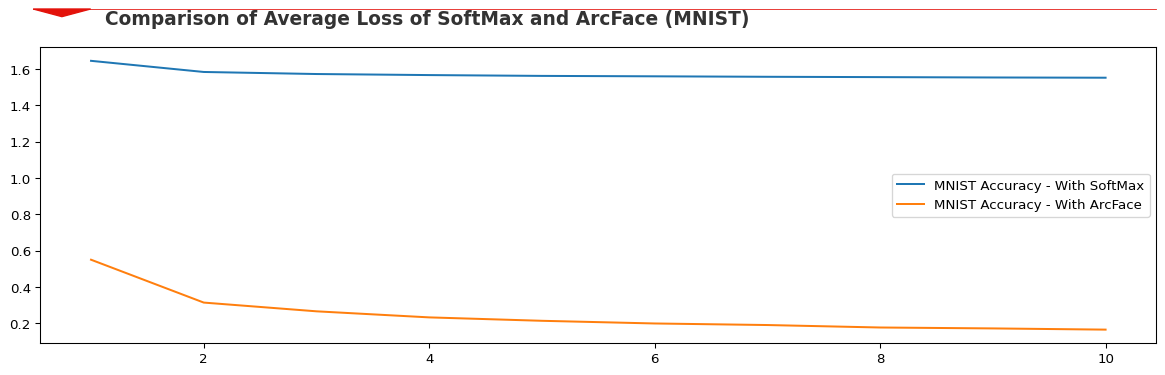

In [4]:
drawSingleLineChart([MNIST_epoch_index_SM, MNIST_epoch_index_AF],
            [MNIST_epoch_loss_SM, MNIST_epoch_loss_AF],
            ["MNIST Accuracy - With SoftMax", "MNIST Accuracy - With ArcFace"],
            "Comparison of Average Loss of SoftMax and ArcFace (MNIST)"
            )

### 4.3.2. Accuracy Comparison

<Figure size 1200x480 with 0 Axes>

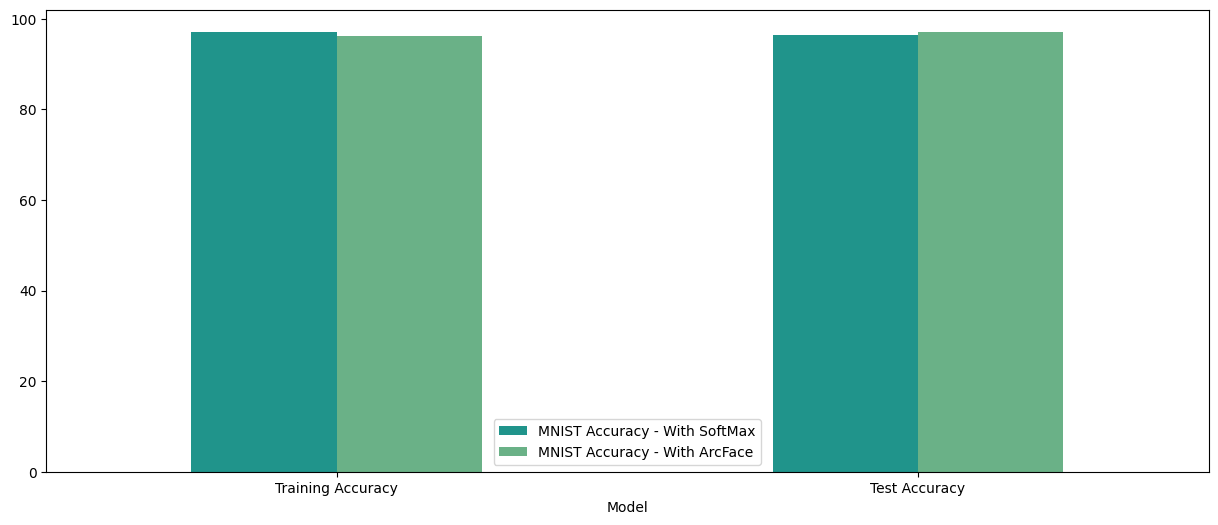

In [5]:
num_accuracy_train_SM   = 97.15
num_accuracy_train_AF   = 96.23
num_accuracy_test_SM    = 96.43
num_accuracy_test_AF    = 97.15

plt.figure(figsize=(15, 6), dpi=80)
df = pd.DataFrame([['Training Accuracy', num_accuracy_train_SM, num_accuracy_train_AF], ['Test Accuracy', num_accuracy_test_SM, num_accuracy_test_AF]], columns=['Model', "MNIST Accuracy - With SoftMax", "MNIST Accuracy - With ArcFace"])
df.plot(x="Model", y=["MNIST Accuracy - With SoftMax", "MNIST Accuracy - With ArcFace"], kind="bar", rot=0, figsize=(15, 6), color=['#20948B', '#6AB187'])
plt.savefig("Accuracy_Comparison_SoftMax_ArcFace_MNIST.png")
plt.show()

# 5. CIFAR10 Dataset training using ArcFace Loss
## 5.1. Network definition for CIFAR10

In [9]:
class Net(nn.Module):
    def __init__(self, dataset, batch_size,
                 hypersphere_radius, margin, num_outputs, num_features, lr):
        super().__init__()
        self.lr                 = lr
        self.dataset            = dataset
        self.batch_size         = batch_size
        self.hypersphere_radius = hypersphere_radius
        self.margin             = margin

        self.conv1  = nn.Conv2d(3, 6, 5,  padding=2)
        self.conv2  = nn.Conv2d(6, 16, 5, padding=2)
        self.conv3  = nn.Conv2d(16, 10, 3,padding=1)
        self.pool   = nn.MaxPool2d(2, 2)
        self.fc1    = nn.Linear(10 * 4 * 4, 120)
        self.fc2    = nn.Linear(120, 84)
        self.fc3    = nn.Linear(84, num_features)

        # Weight matrix
        self.weight = nn.Parameter(torch.randn(num_outputs,num_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        nn_conv1 = F.relu(self.conv1(x))
        nn_maxp1 = self.pool(nn_conv1)

        nn_conv2 = F.relu(self.conv2(nn_maxp1))
        nn_maxp2 = self.pool(nn_conv2)

        nn_conv3 = F.relu(self.conv3(nn_maxp2))
        nn_maxp3 = self.pool(nn_conv3)

        nn_flatn = torch.flatten(nn_maxp3, 1)

        nn_fcls1 = self.fc1(nn_flatn)
        nn_relu1 = F.relu(nn_fcls1)

        nn_fcls2 = self.fc2(nn_relu1)
        nn_relu2 = F.relu(nn_fcls2)

        nn_outpt = self.fc3(nn_relu2)

        norm_embeddings       = normalize(nn_outpt)
        norm_weight_activated = normalize(self.weight)

        logits                = linear(norm_embeddings, norm_weight_activated)
        logits                = logits.clamp(-1, 1)
        return logits

## 5.2. Hyper-parameters and training model

In [10]:
hparams_net = {'dataset':'CIFAR10', 'batch_size':1,
            'hypersphere_radius': 10, 'margin': 0.001, 'num_outputs': 10, 'num_features': 42, 'lr': 0.001}
model_net   = Net(**hparams_net)

CIFAR10_epoch_index, CIFAR10_epoch_loss, CIFAR10_train_accuracy, CIFAR10_test_accuracy = train_network(model_net, epochs=20)

print('CIFAR10_epoch_index    =', CIFAR10_epoch_index)
print('CIFAR10_epoch_loss     =', CIFAR10_epoch_loss)
print('CIFAR10_train_accuracy =', CIFAR10_train_accuracy)
print('CIFAR10_test_accuracy  =', CIFAR10_test_accuracy)

Files already downloaded and verified
Files already downloaded and verified
Epoch: [1] loss: 1.719585  Train accuracy: 36.79%  Test accuracy: 46.05%
Epoch: [2] loss: 1.346878  Train accuracy: 51.56%  Test accuracy: 56.63%
Epoch: [3] loss: 1.175243  Train accuracy: 58.37%  Test accuracy: 61.91%
Epoch: [4] loss: 1.075047  Train accuracy: 61.93%  Test accuracy: 64.02%
Epoch: [5] loss: 1.010710  Train accuracy: 64.32%  Test accuracy: 68.07%
Epoch: [6] loss: 0.959783  Train accuracy: 66.25%  Test accuracy: 68.93%
Epoch: [7] loss: 0.914525  Train accuracy: 67.90%  Test accuracy: 69.44%
Epoch: [8] loss: 0.881841  Train accuracy: 69.07%  Test accuracy: 70.41%
Epoch: [9] loss: 0.848362  Train accuracy: 70.08%  Test accuracy: 72.07%
Epoch: [10] loss: 0.822727  Train accuracy: 71.11%  Test accuracy: 72.80%
Epoch: [11] loss: 0.796833  Train accuracy: 72.06%  Test accuracy: 74.62%
Epoch: [12] loss: 0.775229  Train accuracy: 72.85%  Test accuracy: 74.03%
Epoch: [13] loss: 0.755214  Train accuracy: 7

## 5.3. Results

### 5.3.1. Loss Comparison

In [6]:
CIFAR10_epoch_index_SM = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
CIFAR10_epoch_loss_SF  = [1.8622534581065178, 1.407393115401864, 1.2491992432817818, 1.1511622813501954, 1.0825562077215314, 1.0323491052523255, 0.9984425537907332, 0.9678339629153907, 0.9435341529017268, 0.920001885069646, 0.9076309599392675, 0.8952703119295277, 0.8828700955966208, 0.8705576138171182, 0.8673537508513219, 0.8536305137653835, 0.8456085153040174, 0.8409987401247583, 0.8359231051312992, 0.8287236437221057]

CIFAR10_epoch_index_AF = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
CIFAR10_epoch_loss_AF  = [1.71958468519561, 1.346877714983523, 1.1752429775529727, 1.0750474903980736, 1.0107102363847662, 0.9597830587839056, 0.914525376445828, 0.8818408868418541, 0.8483616817883541, 0.822726789570041, 0.7968327514273371, 0.7752289988959348, 0.7552139981545228, 0.7353788995629339, 0.717390406039718, 0.7019112003077683, 0.6857653808864055, 0.6684635128455633, 0.6551170582991338, 0.6390180611157034]

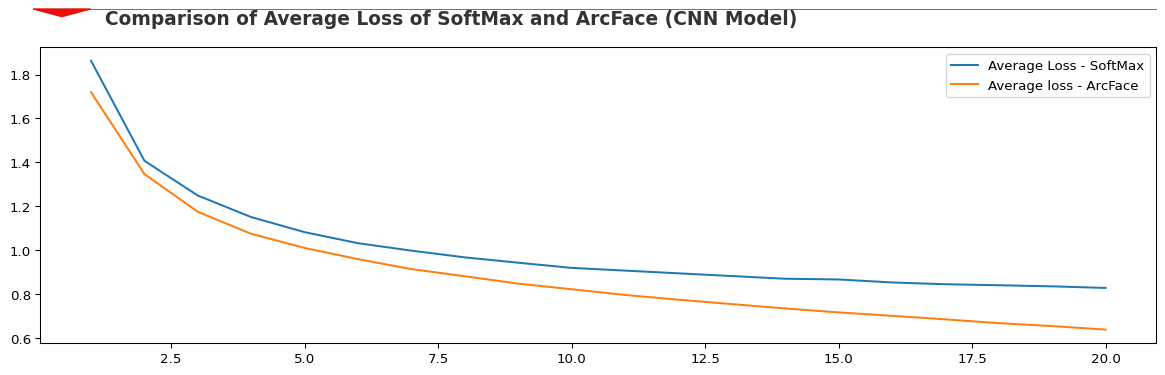

In [7]:
drawSingleLineChart([CIFAR10_epoch_index_SM, CIFAR10_epoch_index_AF],
            [CIFAR10_epoch_loss_SF, CIFAR10_epoch_loss_AF],
            ["Average Loss - SoftMax", "Average loss - ArcFace"],
            "Comparison of Average Loss of SoftMax and ArcFace (CNN Model)"
            )

### 5.3.2. Accuracy Comparison

<Figure size 1200x480 with 0 Axes>

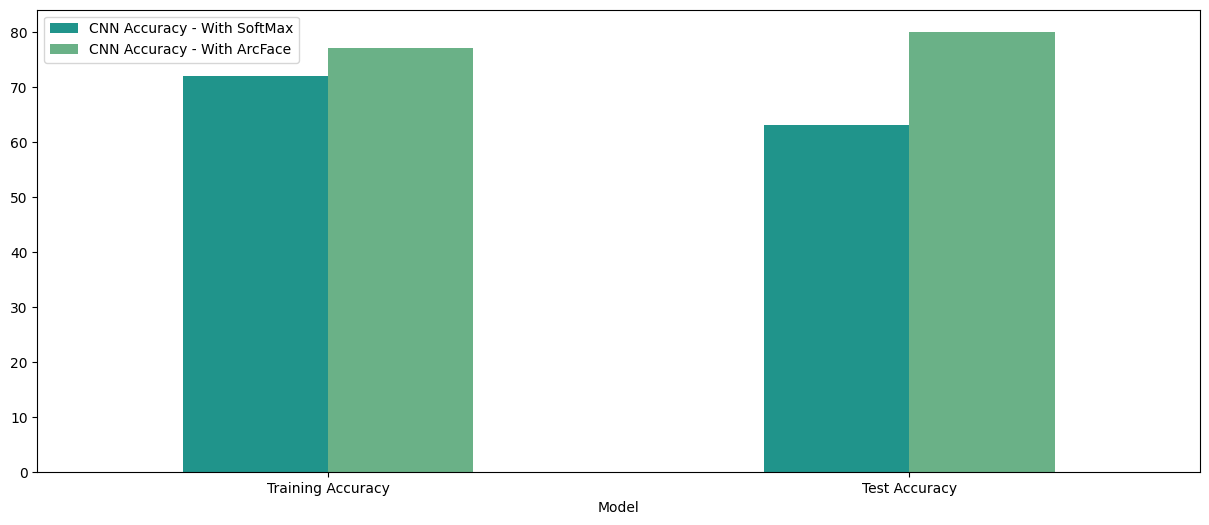

In [8]:
num_accuracy_train_SM   = 72
num_accuracy_train_AF   = 77
num_accuracy_test_SM    = 63
num_accuracy_test_AF    = 80

plt.figure(figsize=(15, 6), dpi=80)
df = pd.DataFrame([['Training Accuracy', num_accuracy_train_SM, num_accuracy_train_AF], ['Test Accuracy', num_accuracy_test_SM, num_accuracy_test_AF]], columns=['Model', "CNN Accuracy - With SoftMax", "CNN Accuracy - With ArcFace"])
df.plot(x="Model", y=["CNN Accuracy - With SoftMax", "CNN Accuracy - With ArcFace"], kind="bar", rot=0, figsize=(15, 6), color=['#20948B', '#6AB187'])
plt.savefig("Accuracy_Comparison_SoftMax_ArcFace_CNN.png")
plt.show()